In [16]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Concatenate,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist

In [18]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [19]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [20]:
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

Text(0.5, 1.0, '(Label: T-shirt/top)')

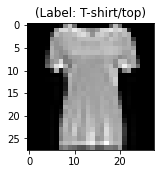

In [21]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train[10], (28,28))
curr_lbl = y_train[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [22]:
# Data Preprocessing
x_train = x_train.reshape(-1, 28,28, 1)
x_test = x_test.reshape(-1, 28,28, 1)
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [23]:
# Validation dtypes, range
x_train.dtype, x_test.dtype, np.max(x_train), np.max(x_test)

(dtype('uint8'), dtype('uint8'), 255, 255)

In [24]:
# Scaling
x_train = x_train / np.max(x_train)
x_test = x_test / np.max(x_test)
np.max(x_train), np.max(x_test)

(1.0, 1.0)

## Autoencoder to understand the data

In [25]:
## Spliting training data to train and validate
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(x_train,
                                                             x_train,
                                                             test_size=0.1,
                                                             random_state=13)

In [26]:
# Basic autoenc params
batch_size = 64
epochs = 200
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [27]:
# Enc/Dec functions, we will only use the enc part for later
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [28]:
# Train the autoenc
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_18 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_19 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0   

In [29]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/200
844/844 [==============================] - 16s 17ms/step - loss: 0.0140 - val_loss: 0.0081
Epoch 2/200
844/844 [==============================] - 14s 16ms/step - loss: 0.0077 - val_loss: 0.2581
Epoch 3/200
844/844 [==============================] - 13s 16ms/step - loss: 0.0073 - val_loss: 0.0077
Epoch 4/200
844/844 [==============================] - 13s 16ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 5/200
844/844 [==============================] - 13s 16ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 6/200
844/844 [==============================] - 13s 16ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 7/200
844/844 [==============================] - 13s 16ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 8/200
844/844 [==============================] - 13s 16ms/step - loss: 0.0037 - val_loss: 0.0072
Epoch 9/200
844/844 [==============================] - 13s 16ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 10/200
844/844 [==============================] - 15s 17ms/step - l

### Visualizing the training part. 
Looks good, no overfitting since both losses are going down.



<function matplotlib.pyplot.show(*args, **kw)>

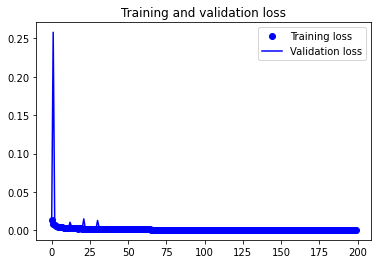

In [30]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show

In [31]:
autoencoder.save('./models/autoencoder.h5')

## Training a classifer on top of the embeddings

In [32]:
autoencoder = load_model('./models/autoencoder.h5')

In [33]:
# OHE for labels (originally categorical)
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test)

In [192]:
## Since we have to use minimum labeled samples from training, we do it this way:
## we iterate using n (labeled) samples at a time, see how our model performs and minimize n.
## note: in the autoenc above we used all samples but we did not use any labels ;)

def fc(enco):
    flat = Flatten()(enco)
    den = Dense(64, activation='tanh')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

def train_classifier(n):
  """
  this fn defines the full model: encoder from autoencoder + simple classifier
  creates a new 'full_model' classifier
  the target is the class

  Input: n=the number of samples to consider in training data 
  Returns: model
  """
  assert n!=0

  #we take a total of n samples: 0.2n in test -> 0.8n in train, shuffling is handled by train_test_split
  train_X,valid_X,train_label,valid_label = train_test_split(x_train,train_Y_one_hot,train_size=int(0.99*n), test_size=int(0.01*n),random_state=7)
  
  print(np.shape(train_X), np.shape(valid_X)) #basic assert
  
  encode = encoder(input_img)
  full_model = Model(input_img,fc(encode))

  #set weights
  for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

  
  for layer in full_model.layers[0:19]:
    layer.trainable = True

  #compile the model
  #the only var here is the size of training data
  full_model.compile(loss=categorical_crossentropy, optimizer=Adam() ,metrics=['accuracy'])
  print(full_model.get_weights()[0][1])
  print(autoencoder.get_weights()[0][1])
  classify_train = full_model.fit(train_X, train_label, batch_size=100,epochs=60,verbose=1,validation_data=(valid_X, valid_label))
  loss = classify_train.history['loss']
  val_loss = classify_train.history['val_loss']
  acc = classify_train.history['accuracy']
  val_acc = classify_train.history['val_accuracy']
  epochs = range(60)
  plt.figure()
  plt.ylim(0.5,1.2)
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'go', label='Val loss')
  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Val acc')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show

  full_model.save(f'./models/classification_complete_{n}.h5')
  return full_model

In [193]:
# from sklearn.metrics import accuracy_score
def calculate_metrics(model):
  """
  takes in the full_model, returns loss,acc
  """
  
  # note: we could also use the eval method to calculate accuracy:
  # test_eval = model.evaluate(x_test, test_Y_one_hot, verbose=0)
  # model_loss, model_acc = test_eval[0], test_eval[1]
  # we do rounding for more accurate results

  y_pred = model.predict(x_test)
  y_pred = np.argmax(np.round(y_pred),axis=1)

  model_acc = accuracy_score(y_test, y_pred)
  return model_acc

(5939, 28, 28, 1) (59, 28, 28, 1)
[[[ 0.17960791  0.07543183  0.18482088  0.3080404  -0.20818645
   -0.03674788 -0.19870181  0.0281267  -0.43410698  0.14069062
   -0.08149236  0.01538937 -0.03276083 -0.21810678  0.13689558
   -0.12765189 -0.11696493  0.04571597  0.5542958  -1.2219586
   -0.4128435   0.11068984 -0.05509845 -0.88018674  0.49373636
   -1.4402426  -0.50847334 -0.4757487  -0.63492036  0.01766208
   -0.05883409  0.2063197 ]]

 [[ 0.4376248  -0.25332198 -0.48668444 -0.62781596 -0.13852984
    0.16677736  0.17161024 -0.04690477  0.5304402   0.4333247
   -0.62823236  0.37262744 -0.00746595 -0.3593421   0.44353688
    0.44590104  0.4621994   0.27729172  0.1627767  -0.6659201
   -0.81743175 -0.49834695  0.69781995 -0.62456244 -0.77836806
   -0.25319362  0.13053253  0.40791398  0.46675915 -0.10575999
   -0.14844456  0.69376695]]

 [[ 0.09916951 -0.18255913  0.22781664 -0.35778022  0.09373383
    0.3941446   0.03869203 -0.1000521   0.09301855 -0.53915524
    0.3770111   0.2518045  

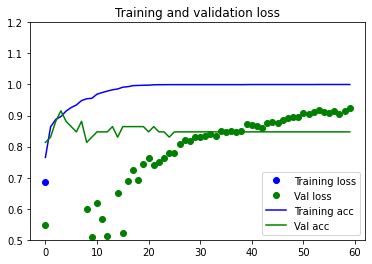

In [194]:
minimum_labeled_samples = [5999]


for n in minimum_labeled_samples:
  model = train_classifier(n)
  model_acc = calculate_metrics(model)
  print(f"Test Accuracy: {model_acc}")
  with open("./results.txt", mode="a") as f:
    f.write(f"\n{n}\t{model_acc}")

<function matplotlib.pyplot.show(*args, **kw)>

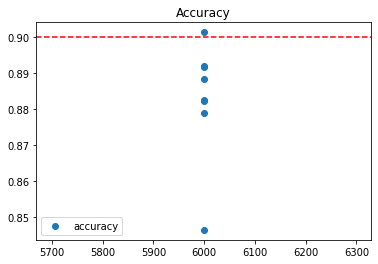

In [203]:
## Plot acc vs sample size of labeled data
with open('./results.txt', 'r') as f:
  next(f) #header
  data = [line.strip('\n').split('\t') for line in f]
  data = np.array([[float(a), float(b)] for a,b in data])
plt.scatter(x=data[:,0], y=data[:,1], label='accuracy')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Accuracy')
plt.legend()
plt.show

In [196]:
from sklearn.metrics import classification_report

full_model = load_model('./models/classification_complete_5999.h5')

predicted_classes = full_model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

target_names = [f"{label_dict[i]}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.85      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.87      0.86      0.87      1000
       Dress       0.90      0.90      0.90      1000
        Coat       0.84      0.87      0.86      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.75      0.70      0.73      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Found 9013 correct labels


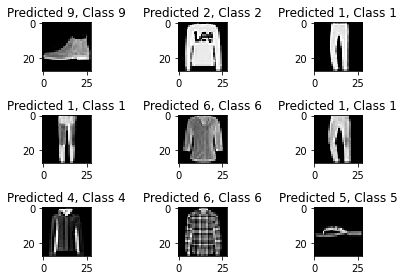

In [202]:
correct = np.where(predicted_classes==y_test)[0]
print ("Found %d correct labels"% len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()

Found 987 correct labels


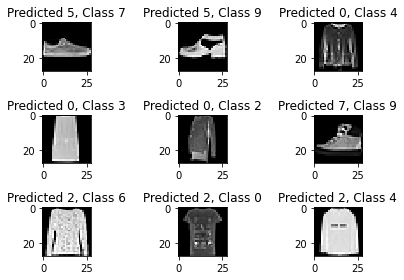

In [198]:
incorrect = np.where(predicted_classes!=y_test)[0]
print ("Found %d correct labels"% len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()